# Projet Lignes de niveau

On importe ces modules par principe de precaution

In [32]:
import autograd
from autograd import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

 Ceci est le notebook Jupyter contenant le projet de dessin de lignes de niveau sous python de Maud Roux-Salembien et Jérémy Costanzo

Soit f une fonction de $[0,1]^2$ vers $\mathbb{R}$ supposée continuement différentiable.

On cherche les ensembles de la forme : {$(x,y)\in\mathbb{R}^2|f(x,y)=c$} où c $\in$ $\mathbb{R}$



## <u>Contour simple</u>

### Amorce : 

Soit c $\in$ $\mathbb{R}$

On cherche une condition suffisante sur f(0,0) et f(0,1) pour qu'il existe t $\in$ [0,1] tel que f(0,t) = c

On sait que f est continuement différentiable, donc en particulier f(0,.), qui désigne la fonction $\begin{align*}
  [0,1] &\to \mathbb{R}\\
  t &\mapsto f(0,t).
\end{align*}$
est continue.


Ainsi, si c appartient au segment [min(f(0,0),f(0,1)),max(f(0,0),f(0,1))], le théorème des valeurs intermédiaires nous assure l'existence d'un t $\in$ [0,1] solution de f(0,t) = c.

Si la condition évoquée est satisfaite, on peut chercher numériquement une solution en utilisant la méthode de la dichotomie :

In [33]:
def find_seed(g,c=0,eps=2**(-26)):
    if (g(0)-c)*(g(1)-c) > 0:
        return None
    else:
        a = 0
        b = 1
        while b-a > eps:
            m = (a+b)/2
            if (g(m)-c)*(g(a)-c)<=0:
                b = m
            else:
                a = m
        t = (a+b)/2
        return t

La méthode des tangentes de Newton converge plus rapidement, mais nécessite plus d'hypothèses, et on ne peut pas savoir à quel point on est éloigné d'une solution, alors que la méthode de la dichotomie ne nécessite que la continuité de g, et permet de majorer la distance à une solution.

### Propagation

Une première approche pour implémenter la fonction simple_contour consisterait à subdiviser [0,1] en segments de taille $\delta$, et d'utiliser find_seed(g,c,eps) où g est la fonction $\begin{align*}
  [0,1] &\to \mathbb{R}\\
  t &\mapsto f(k\delta,t)
\end{align*}$ où k varie de 0 à int(1/$\delta$). Mais cela n'est pas satisfaisant, il faudrait réaliser environ 1/$\delta$ dichotomies, et l'équation f(k$\delta$,t) = c peut admettre plusieurs solutions éloignées les unes des autres.

Pour la suite, nous avons besoin de calculer le gradient de f en un point. Ainsi nous implementons une classe pt qui permet de representer des elements de $\mathbb{R}^2$, donc des points ou des vecteurs.

In [34]:
tolerance = 1**(-7) #un petit flottant, choisi un peu au pif pour l'instant...

class pt:
    def __init__(self,x=0.0,y=0.0):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return('{'+str(self.x)+','+str(self.y)+'}')
        
    def __mul__(a,b):
        if isinstance(b,int) or isinstance(b,float):
            return pt(a.x*b,a.y*b)
        else:
            return pt(a.x*b.x,a.y*b.y)
            
    def __rmul__(a,b):
        if isinstance(a,int) or isinstance(a,float):
            return pt(a*b.x,a*b.y)
        else:
            return a*b
    def __neg__(self):
        return pt(-self.x,-self.y)
        
    def __add__(a,b):
        return pt(a.x+b.x,a.y+b.y)  
    
    def __inv__(self):
        return pt(1/self.x,1/self.y)
    
    def __div__(self,b):
        return (self * (1/b))
    
    def __rdiv__(self,b):
        return pt(b.x/self,b.y/self)
    
    def norme(self):
        return (self.x**2 + self.y**2)**0.5

    def normalized(self):
        return(self*(1/(self.norme())))
        
    def __sub__(self,b):
        return self+ (-b)
        
    def orth(self):
        return pt(-self.y,self.x)

def list_x_y(p):
    x,y = [],[]
    for i in p:
        x.append(i.x)
        y.append(i.y)
    return(np.array(x),np.array(y))
    
def dist(a,b):
    return (a-b).norme()
    
def grad(f,p=pt()):
    autog = autograd.grad
    t = np.r_[autog(f,0)(p.x,p.y),autog(f,1)(p.x,p.y)]
    return pt(t[0],t[1])

Nous implementons maintenant la fonction ingrid : ingrid(p,grid) renvoie : p $\in$ grid ou grid est en fait un ensemble de la forme [a,b]x[c,d] où (a,b,c,d) $\in \mathbb{R}^4$.

In [37]:
def ingrid(p,grid):
    return(grid[0]<=p.x<=grid[1] and grid[2]<=p.y<=grid[3])    

Dans un premier temps nous avons utilisé la méthode du gradient : $x_{n+1}$ est obtenu en se déplaçant de $delta$ dans
la direction de l'orthogonal au gradient en $x_{n}$. Dans la plupart des cas on a avec cette méthode deux directions possibles. On choisit celle qui nous amène le plus loin de l'avant dernier point calculé ($x0$). Cette fonction prend en argument $f$, la grille dans laquelle on veut tracer la ligne de niveau $grid$, $cote$ la fonction qui nous indique sur quel côté de la grille chercher le premier point, $delta$ la distance entre deux points consécutifs de la ligne de niveau.

In [63]:
def simple_contour(f, grid, cote, c=0.0, delta=0.01):
    x=[]
    y=[]
    t = find_seed(cote, c)
    if t == None:
        return (x,y)
    else :
        x0 = pt(grid[0], t)
        h=grad(f, x0)
        a = x0 + (h.normalized().orth() * delta)
        b = x0 - (h.normalized().orth() * delta)
        if not ingrid(a, grid):
            x1 = b
        else:
            x1 = a
        while len(x) < 1000:  #la condition devrait être while ingrid(x1, grid) mais pour les besoins de 
            x.append(x1.x)     #la démonstration on fait autrement
            y.append(x1.y)
            h=grad(f, x1)
            a = x1 + (h.normalized().orth() * delta)
            b = x1 - (h.normalized().orth() * delta)
            if dist(x0, a) > dist(x0, b):
                x0 = x1
                x1 = a
            else:
                x0 = x1
                x1 = b
    return (x,y)
        

Cette fonction pose un problème : la nouvelle valeur calculée avec le gradient est une approcimation et les erreurs pour chaque $x_{n}$ s'additionnent. L'erreur se propage, si bien que si nous voulions tracer un cercle, on se retrouve plutôt avec une spirale :

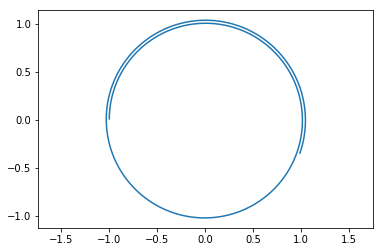

In [64]:
def f(x,y):
    return(x**2+y**2)

plt.axis('equal')
grid1=[-1.,1.3,-1.3,1.3]

s=simple_contour(f, grid1, lambda x:f(grid1[0],x), c = 1.)
plt.plot(s[0],s[1])

Les fonctions suivantes permettent de se reperer sur un cercle de rayon delta centre sur un point p0.

In [36]:
def p_a1(ang):
    """
    Cette fonction calcule le point p sur le cercle unite tel que l'angle oriente (pt(1,0),p) vale ang
    """
    return(pt(np.cos(ang),np.sin(ang)))    

def rad(p):
    """
    Cette fonction calcule l'angle oriente (pt(1,0),p)
    """
    pn = p.normalized()
    x = pn.x
    y = pn.y
    if y > 0:
        return np.arccos(x)
    else:
        return -np.arccos(x)
    
def theta(p0,p):
    """
    calcule l'angle oriente (p0+pt(delta,0),p) ou delta = dist(p0,p)
    """
    return rad(p) - rad(p0)

def p_a(p0,th,delta):
    """
    calcule le point p tel que dist(p,p0) = delta et theta(p0,p) = th
    """
    p = delta*p_a1(th)
    return(p0+p)

Nous avons d'abord pensé à utiliser la méthode de newton à une dimension. Pour cela on cherche le point $n+1$ de la suite dans un cercle de rayon delta autour du point n. Chaque point du cercle est alors défini par un angle $\theta$, compté dans le sens direct. En utilisant la relation entre $\theta$ et les coordonnées du point $(x,y)$ sur le cerle on définit une fonction d'une variable $g(\theta)=f(x,y)$ pour tout $(x,y)$ dans le cercle qui nous intéresse. On applique alors la méthode de newton à la fonction $g$. Pour les conversions entre point et angle on utilise les fonctions précédentes.

La fonction suivant permet d'obtenir une première approximation du point $n+1$ en utilisant la méthode du gradient. Elle prend en argyment f la fonction dont on veut tracer les lignes de niveau, ad l'avant-dernier point de notre liste de points, d le dernier point calculé, delta la distance entre deux points de la suite et grid la grille dont on ne doit pas sortir pour tracer les lignes de niveau. L'hortogonal au gradient nous donne deux directions dans lesquelles nous pouvons aller (dans la majorité des cas, sauf point particulier). Afin d'éviter de revenir sur nos pas nous choisissons celle qui nous amène le plus loin de l'avant-dernier point. 

In [30]:
def suivant(f, ad, d, delta, grid):
    h=grad(f,d[0])
    p11 = d[0] + (h.normalized().orth() * delta)
    p12 = d[0] - (h.normalized().orth() * delta)   #on utilise le gradient pour aller au prochain point  
    p1=pt()                                               #mais sans sortir de la grille

    if dist(ad[0], p11)> dist(ad[0], p12):
        if ingrid(p11,grid):
            p1=p11
        else:
            raise ValueError("on sort de la grille")           
    else:
        if ingrid(p12,grid):
            p1=p12
        else:
            raise ValueError("on sort de la grille")
    prochain=theta(d[0],p1)
    return((p1,prochain))

On corrige ensuite la valeur obtenue en utlisant la méthode des tangentes de Newton à la fonction g définie plus haut. 
On se place dans un cercle de rayon delta autour de du dernier point de la liste, le point obtenu grâce à suivant 
est le premier de la suite. 
On définit g et sa dérivée dg. Elles prennent pour argument $x$ le dernier point de la liste (on cherche le nouveau point dans un cercle de rayon delta autour de $x$), $\theta_{n}$ l'angle entre le point $x_{n}$ de la suite de Newton et $x$, $d$ le rayon du cercle et revoient $g(\theta_{n})$ (resp. $dg(\theta_{n})$).

In [23]:
def g(x, theta, d=0.01) :
    return f(x.x+d*np.cos(theta), x.y+d*np.sin(theta))
def dg(x, theta, d=0.01):
    return (-d*np.sin(theta)*autograd.grad(f,0)(x.x+d*np.cos(theta),x.y+d*np.sin(theta)) + d*np.cos(theta)*autograd.grad(f,1)(x.x+d*np.cos(theta),x.y+d*np.sin(theta)))

Voici la fonction Newton qui prend en argument $r$ le centre du cercle dans lequel on cherche le prochain point, $d = [x_{n},\theta_{n}]$, $delta$ le rayon du cercle, $c$ la valeur qu'a la fonction sur la ligne de niveau et renvoie $d = [x_{n+1},\theta_{n+1}]$

In [24]:
def newton(r, d, delta, c):
    derivee=dg(r, d[1],delta)                                  
    if abs(derivee) < 10**(-26):
        print("la dérivée est trop petite") #si la dérivée s'annule on renvoie la dernière valeur calculée avec Newton
        return (d[0],d[1])                                  
    else:
        return (p_a(r, d[1]-(g(r, d[1],delta) - c)/derivee, delta),d[1]-(g(r,d[1],delta) - c)/derivee)

On peut maintenant écrire simple_contour_un. Elle prend en arguments $f$ dont on trace la ligne de niveau, $c$ la valeur de $f$ sur cette ligne, $delta$ la distance entre deux points consécutifs de la ligne, $grid$ la grille dans laquelle on trace la ligne de niveau et $cote$ la fonction qui indique sur quel côté de la grille chercher le premier point de la ligne de niveau.

In [42]:
def simple_contour_un(f, cote, c=0.0,delta=0.01,grid=[0.,1.,0.,1.]):
    t = find_seed(cote,c)
    if t == None:
        return [],[]
    p0 = pt(grid[0],find_seed(cote,c))
    g0 = grad(f,p=p0)
    p11 = p0 + (g0.normalized().orth() * delta)
    p12 = p0 - (g0.normalized().orth() * delta)

    p1 = pt()
    
    if ingrid(p11,grid):
        p1 = p11
    elif ingrid(p12,grid):
        p1 = p12
    else:
        return [],[]
    
    t1=theta(p0,p1) #pi --> point    ti --> angle
    
    p2, t2 = newton(p1, [p1, t1], delta, c)
    
    pa = p0 #avant-avant dernier point calculé
    ta = 0.
    pb = p1 #avant-dernier
    tb = t1
    pc = p2 #dernier point calculé
    tc = t2
    
    pts=[p0, p1]
    ref=p1  #ref représente le dernier point enregistré dans la liste. On cherche le prochain point dans un cercle 
                #de rayon delta, en première approximation avec suivant puis en corrigeant grâce à newton

    try :
        while dist(pc,pa) >= delta/2 and len(pts)<10000:
        
            pb, tb = newton(ref, [pa,ta], delta, c)
            pc, tc = newton(ref, [pb,tb], delta, c)

            while dist(pc,pb)>10**(-15):
                pa = pb    
                ta = tb
                pb = pc
                tb = tc
                pc, tc = newton(ref, [pb,tb], delta, c)  #on cherche le point sur le cercle avec newton
  
            if not ingrid(pc,grid):
                return list_x_y(pts)
            else:
                pd = pts[-1]
                td = theta(pts[-2],pd)
                ref = pc
                pts.append(pc)
                pa, ta = suivant(f, [pd,td], [pc,tc], delta, grid) #on change de point avec suivant
 
    except ValueError as e:
        print(e)
    return list_x_y(pts)

Cependant cette fonction ne marche pas dans tous les cas et nous n'avons pas réussi à la débugger :

on sort de la grille


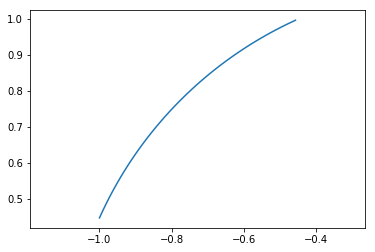

In [31]:
def f(x,y):
    return(x**2+y**2)

plt.axis('equal')
grid1=[-1.,1.,-1.,1.]

s=simple_contour_un(f, lambda x:f(grid1[0],x), c=1.2, grid=grid1)
plt.plot(s[0],s[1])

In [2]:
def newton(f,p0,c,eps=10**-4):
    def fun(x,y):
        return (f(x,y)-c)
    def proch(p): #proch joue le role de l'application contractante pour l'application du theoreme du point fixe
        g = grad(f,p)
        return(p - (fun(p.x,p.y)/(g.norme()**2))*g)
    p1 = proch(p0)
    while dist(p0,p1) > eps:
        p0 = p1
        p1 = proch(p1)
    return(p1)

def g(f,p0,theta,d) :
    return f(p0.x+d*np.cos(theta),p0.y+d*np.sin(theta))

def dichotoproch(f,c,delta,ad,d):
    ref = (d - ad) + d
    ang = theta(d + pt(delta,0),ref)
    def rech(th):
        return g(f,d,th-ang,delta)
    a = -np.pi + delta
    b =  np.pi - delta
    while b-a > delta:
        m = (a+b)/2
        if (rech(m)-c)*(rech(a)-c)<=0:
            b = m
        else:
            a = m
    t = (a+b)/2
    return p_a(d,t+ang,delta)

In [10]:
theta(pt(1,1),pt(0.2,2))

0.6857295109062861

Description de suivant, de la methode des tangentes, contour simple...

In [11]:
def suivant(f,ad,d,c,delta):
    p0 = d + delta*grad(f,d).normalized().orth()
    p1 = d - delta*grad(f,d).normalized().orth()
    s = pt()
    if dist(p0,ad) > dist(p1,ad):
        s = p0
    else:
        s = p1
    pr = newton(f,s,c,delta*tolerance)
    return(pr)

def simple_contour(f,c=0.0, delta =0.01,grid = [0.0,1.0,-1.0,1.0],cote= lambda x: f(0,x),i = 0): #i designe le cote de la grille : il appartient à [|0,3|]
    t = find_seed(cote,c)
    if t == None:
        return [],[]
    p0 = pt()
    if i < 2:
        p0 = pt(grid[i],find_seed(cote,c))
    else:
        p0 = pt(find_seed(cote,c),grid[i])
    g0 = grad(f,p0)
    p11 = p0 + (g0.normalized().orth() * delta)
    p12 = p0 - (g0.normalized().orth() * delta)
    p1t = pt()
    if ingrid(p11,grid):
        p1t = p11
    elif ingrid(p12,grid):
        p1t = p12
    else:
        return [],[]
    p1 = newton(f,p1t,c,tolerance*delta)
    p2 = suivant(f,p0,p1,c,delta)
    pts = [p0,p1,p2]
    pa = p0 #avant-avant dernier point calculé
    pb = p1 #avant-dernier
    pc = p2 #dernier point calculé
    compt = 0
    while dist(pc,p0) > delta and dist(pc,pa) > delta and compt < 100000:
        compt += 1
        pa = pb
        pb = pc
        #pc = suivant(f,pb,pc,c,delta)
        pc = dichotoproch(f,c,delta,pa,pb)
        pts.append(pc)
        if not ingrid(pc,grid):
            return list_x_y(pts)
        #else:
        #    if dist(pc,pa) > delta/2:
        #        pts.append(pc)
        #    else:
        #        pc = dichotoproch(f,c,delta,pa,pb)
        #        pts.append(pc)
    return list_x_y(pts)    

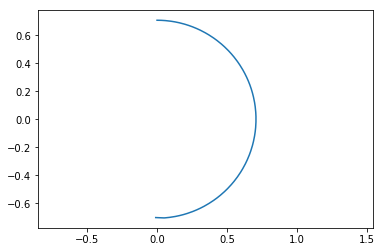

In [12]:
def f(x,y):
    return x**2 + y**2
plt.axis("equal")
si = simple_contour(f,0.5)
plt.plot(si[0],si[1])

## Contour complexe

On veut maintenant quadriller notre espace pour trouver des amorces ailleurs pour les lignes de niveau.
On va appeler contour_simple sur ces grilles.
On définit la fonction bord, qui renvoie une fonction $[0,1] \rightarrow \mathbb{R}$, qui va nous servir à trouver une amorce pour chacun des 4 côtés de la cellule.

In [27]:
def bord(f,p1,p2,n):
                """
                bord(f,p1,p2,n) renvoie une application partielle qui va etre utilisee par find_seed pour trouver une amorce a une ligne de niveau.
                """
                if n == 0:
                    return(lambda x: f(p1.x,p2.y + (p1.y-p2.y)*x))
                elif n == 1:
                    return(lambda x: f(p1.x + (p2.x-p1.x)*x,p1.y))
                elif n == 2:
                    return(lambda t: f(p2.x, p2.y + (p1.y-p2.y)*t))
                elif n == 3:
                    return(lambda t: f(p1.x + (p2.x-p1.x)*t, p2.y))
            
#def contour(f,c=0.0,xc=[0.0,1.0],yc=[0.0,1.0],delta = 0.01):
#    xs,ys = [],[]
#    for i in range(len(xc)-1):
#        for j in range(len(yc)-1):
#            grid = [xc[i],yc[j],xc[i+1],yc[j+1]]
#            p1 = pt(xc[i],yc[i])
#            p2 = pt(xc[i+1],yc[j+1])
#            
#            for n in range(4):    
#                appp = bord(f,p1,p2,n)
#                x,y = simple_contour(f,c,delta,grid,appp,n)
#                xs.append(x)
#                ys.append(y)
#    return(xs,ys)

In [28]:
# Rotators
# ------------------------------------------------------------------------------
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function


# Complex Contouring
# ------------------------------------------------------------------------------

# Customize the simple_contour function used in contour :
# simple_contour = smart_simple_contour


def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves


In [40]:
grille_x = np.linspace(-5,5,20)
grille_y = np.linspace(-5,5,20)

xs,ys = contour(f,1,grille_x,grille_y,0.01)

for x,y in zip(xs,ys):
    plt.plot(x,y)
plt.show()

ValueError: too many values to unpack (expected 2)